In [170]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

!ln -s /Users/marcodia/Research/lowfreq_S2S_project/network_arch.ipynb network_arch.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/metrics.ipynb metrics.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/plot.ipynb plot.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/settings.ipynb settings.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/NN_train_robustness/functions_misc.ipynb functions_misc.ipynb

import network_arch as network
import metrics
import plot
import settings
import functions_misc as funcs

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

ln: network_arch.ipynb: File exists
ln: metrics.ipynb: File exists
ln: plot.ipynb: File exists
ln: settings.ipynb: File exists
ln: functions_misc.ipynb: File exists


## Analyze by Confidence

In [171]:
running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28 #(Nov-Feb)
running_window = running_window_yr * days_per_annualszn
array_size = 100 - running_window_yr
num_experiments = 10
num_seeds = 10 

timeplot = np.arange(1850,1950)
timeplot = timeplot[running_window_yr:(len(timeplot))]

ind = 0 
exp_num = 4

In [172]:
timeplot

array([1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870,
       1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892,
       1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903,
       1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914,
       1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949])

In [173]:
# Create Zeros Arrays

accuracy_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
accuracy_seed_loser_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
least_confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])

# mostconf_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
# mostconf_seed_loser_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
# accuracy_REORDER_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
# leastconf_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
# leastconf_seed_loser_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])

accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
overall_accuracy_all_trained = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])


In [174]:


# Create Zeros Arrays
# accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
# overall_accuracy_all_trained = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
# acc_v_conf_test = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
# acc_v_conf_val = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])


In [175]:
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)

    Xdata_folder = 'exp_1/exp_'+str(sub_exp-(exp_num-1)*100)
    Ydata_folder = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
    
    ddir_X = '/Users/marcodia/Research/Data/processed_fields/Week_45/'+Xdata_folder+'/'
    ddir_Y = '/Users/marcodia/Research/Data/processed_fields/Week_45/'+Ydata_folder+'/'
    ddir_in = ddir_Y #'/Users/marcodia/Research/lowfreq_S2S_project/data_for_publication/'+Ydata_folder+'/'
    ddir_out = ddir_Y# '/Users/marcodia/Research/lowfreq_S2S_project/data_for_publication/'+Ydata_folder+'/'
    ddir_figs = ddir_out
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = 21# params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            accuracy_trained_runavg[ind,ind2,:] = xr.open_dataarray(ddir_in+'accuracy_testdata_'+str(running_window_yr)+'yr_runavg_exp'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'.nc')
            #overall_accuracy_all_trained[ind,:] = xr.open_dataarray(ddir_in+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_in+'20confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds_UPDATED'+'.nc')
            least_confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_in+'80confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds_UPDATED'+'.nc')
            # acc_v_conf_test[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_TESTING_'+EXPERIMENT[-3:]+'_allseeds.nc')
            # acc_v_conf_val[ind,:,:] = xr.open_dataarray(ddir_in+'confidence_vs_accuracy_VALIDATION_'+EXPERIMENT[-3:]+'_allseeds.nc')
            ind2 = ind2+1
    ind = ind+1  
    

In [176]:
# #Reorder so test ensemble members are in correct order
confident_preds_runavg['experiment']= confident_preds_runavg.experiment-1 
confident_preds_runavg_reorder = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
confident_preds_runavg_reorder[0:9,:,:] = confident_preds_runavg[1:10,:,:]
confident_preds_runavg_reorder[9,:,:] = confident_preds_runavg[0,:,:]
confident_preds_runavg = confident_preds_runavg_reorder

least_confident_preds_runavg['experiment']= least_confident_preds_runavg.experiment-1 
least_confident_preds_runavg_reorder = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
least_confident_preds_runavg_reorder[0:9,:,:] = least_confident_preds_runavg[1:10,:,:]
least_confident_preds_runavg_reorder[9,:,:] = least_confident_preds_runavg[0,:,:]
least_confident_preds_runavg = least_confident_preds_runavg_reorder

In [177]:
#Plot Highest Seed from all experiments for running average of accuracy 

#avg_acc_per_seed_trained = np.mean(accuracy_trained,axis=2)
#np.argmax(np.array(avg_acc_per_seed_trained[0,:]))

# for exp in np.arange(0,10):
#     seed_winner_trained = np.argmax(np.array(overall_accuracy_all_trained[exp,:]))
#     accuracy_seed_winner_trained[exp,:] = accuracy_trained_runavg[exp,seed_winner_trained,:]
#     seed_loser_trained = np.argmin(np.array(overall_accuracy_all_trained[exp,:]))
#     accuracy_seed_loser_trained[exp,:] = accuracy_trained_runavg[exp,seed_loser_trained,:]
    
#     mostconf_seed_winner = np.argmax(np.array(overall_accuracy_all_trained[exp,:]))
#     mostconf_seed_winner_trained[exp,:] = accuracy_trained_runavg[exp,seed_winner_trained,:]
#     mostconf_loser_trained = np.argmin(np.array(overall_accuracy_all_trained[exp,:]))
#     mostconf_seed_loser_trained[exp,:] = accuracy_trained_runavg[exp,seed_loser_trained,:]

  

# Look at just most confident predictions

In [178]:
mean_conf_preds = np.mean(confident_preds_runavg, axis=1)
mean_least_conf_preds = np.mean(least_confident_preds_runavg, axis=1)
mean_all_preds = np.mean(accuracy_trained_runavg, axis=1)
#confident_preds_runavg

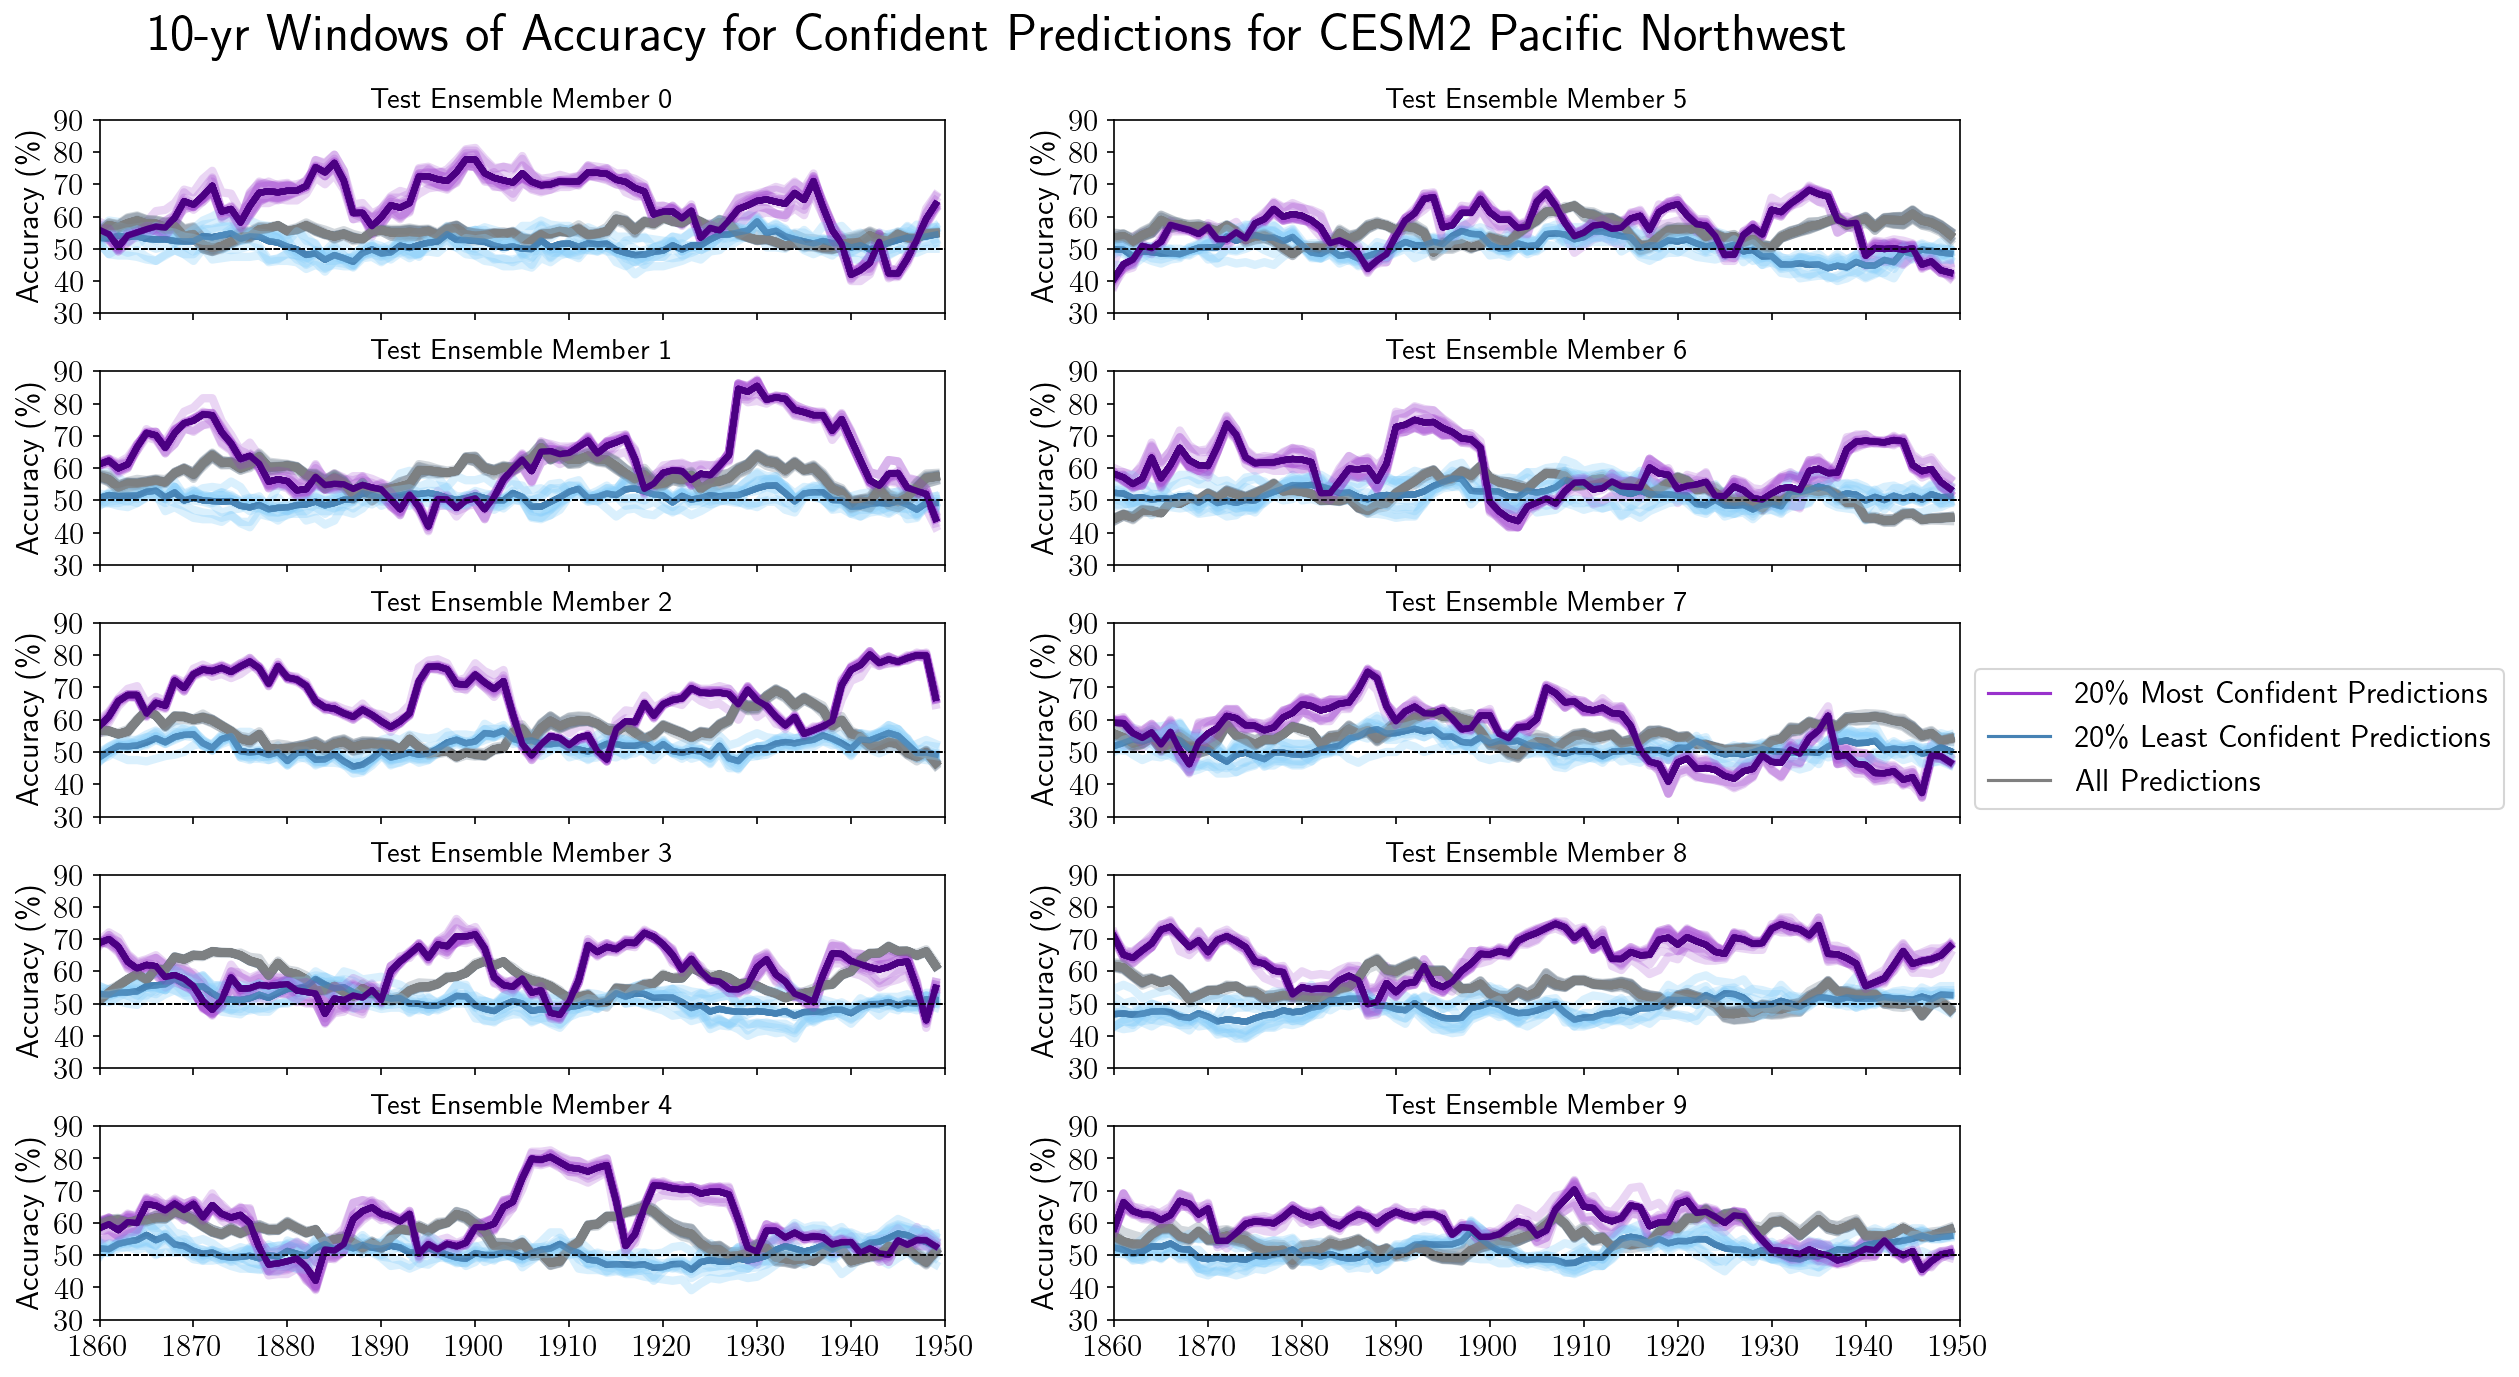

In [181]:
#Plot all the Seeds from all Experiments 
fig, ax = plt.subplots(5,2, sharex= True, figsize=(16,10))

for exp in np.arange(0,10):

    for SEED in np.arange(0,10):
        if exp < 5:
            ax[exp, 0].plot(timeplot, accuracy_trained_runavg[exp,SEED,:], color='slategrey', alpha=0.3, linewidth=4)
            ax[exp, 0].plot(timeplot, mean_all_preds[exp,:], color='gray', alpha=0.6, linewidth=4)
            ax[exp, 0].plot(timeplot, least_confident_preds_runavg[exp,SEED,:],  color='lightskyblue', alpha=0.3, linewidth=4)  
            ax[exp, 0].plot(timeplot, mean_least_conf_preds[exp,:], color='steelblue', alpha=0.6, linewidth=3)
            ax[exp, 0].plot(timeplot, confident_preds_runavg[exp,SEED,:], color='darkorchid', alpha= 0.2,linewidth=4)
            ax[exp, 0].plot(timeplot, mean_conf_preds[exp,:], color='indigo', linewidth=3)    

            
            ax[exp, 0].set(xlim=(timeplot[0],timeplot[-1]+1))
            ax[exp, 0].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
            #ax[exp, 0].set(ylim=(0,100))
            #ax[exp, 0].set(yticks=(np.arange(0,105, step=20)))
            ax[exp, 0].set(ylim=(30,90))
            ax[exp, 0].set(yticks=(np.arange(30,95, step=10)))
            ax[exp, 0].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp, 0].set(ylabel='Accuracy (\%)')
            ax[exp, 0].axhline(y=50, color='black', linestyle='--', linewidth=0.75)
            #print(exp)
        if exp >= 5:
            ax[exp-5,1].plot(timeplot, np.zeros(len(timeplot)),color='darkorchid')
            ax[exp-5,1].plot(timeplot, np.zeros(len(timeplot)),color='steelblue')
            ax[exp-5,1].plot(timeplot, np.zeros(len(timeplot)),color='gray')

            ax[exp-5, 1].plot(timeplot, accuracy_trained_runavg[exp,SEED,:], color='slategrey', alpha=0.3, linewidth=4)
            ax[exp-5, 1].plot(timeplot, mean_all_preds[exp,:], color='gray', alpha=0.6, linewidth=4)
            ax[exp-5, 1].plot(timeplot, least_confident_preds_runavg[exp,SEED,:],  color='lightskyblue', alpha=0.3, linewidth=4)
            ax[exp-5, 1].plot(timeplot, mean_least_conf_preds[exp,:], color='steelblue', alpha=0.6,  linewidth=3)  
            ax[exp-5, 1].plot(timeplot, confident_preds_runavg[exp,SEED,:], color='darkorchid', alpha= 0.2,linewidth=4)
            ax[exp-5, 1].plot(timeplot, mean_conf_preds[exp,:], color='indigo', linewidth=3)
            
            ax[exp-5, 1].set(xlim=(timeplot[0],timeplot[-1]+1))
            ax[exp-5, 1].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
            ax[exp-5, 1].set(ylim=(30,90))
            ax[exp-5, 1].set(yticks=(np.arange(30,95, step=10)))
            #ax[exp-5, 1].set(ylim=(0,100))
            #ax[exp-5, 1].set(yticks=(np.arange(0,105, step=20)))
            #ax[exp-5, 1].set_title('Experiment '+str(exp_num)+'0'+str(exp),fontsize =14)
            ax[exp-5, 1].set_title('Test Ensemble Member '+str(exp),fontsize =14)
            ax[exp-5, 1].set(ylabel='Accuracy (\%)')
            ax[exp-5, 1].axhline(y=50, color='black', linestyle='--', linewidth=0.75)

labels = ['20\% Most Confident Predictions','20\% Least Confident Predictions', 'All Predictions']
fig.subplots_adjust(top=0.91, hspace=0.3)
plt.suptitle((str(running_window_yr)+'-yr Windows of Accuracy for Confident Predictions for CESM2 Pacific Northwest'), fontsize='25')
plt.legend(labels, loc='center left',ncol=1, bbox_to_anchor=(1, 3.0))

#plt.savefig(ddir_figs+'accuracy_vs_confidence_20percmost_leastconfident'+str(running_window_yr)+'yr_runavg_exp_'+REGION_TAND+'_allseeds.png', format='png')

In [180]:
print(np.max(mean_conf_preds,axis=1))

<xarray.DataArray (experiment: 10)>
array([77.75      , 85.5       , 80.20833333, 71.91666667, 80.5       ,
       68.25      , 74.95833333, 74.83333333, 74.75      , 70.375     ])
Coordinates:
  * experiment  (experiment) int64 0 1 2 3 4 5 6 7 8 9


In [168]:
print(np.min(mean_conf_preds,axis=1))

<xarray.DataArray (experiment: 10)>
array([49.58333333, 45.29166667, 49.83333333, 44.45833333, 46.58333333,
       42.45833333, 39.90024205, 38.        , 44.33333333, 50.16666667])
Coordinates:
  * experiment  (experiment) int64 0 1 2 3 4 5 6 7 8 9


In [142]:
print(np.max(mean_conf_preds,axis=1) - np.min(mean_conf_preds,axis=1))

<xarray.DataArray (experiment: 10)>
array([27.54166667, 41.33333333, 41.25      , 34.        , 32.08333333,
       28.79166667, 37.29166667, 35.58333333, 51.875     , 41.04166667])
Coordinates:
  * experiment  (experiment) int64 0 1 2 3 4 5 6 7 8 9


(array([1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950]),
 [Text(1860, 0, '$\\mathdefault{1860}$'),
  Text(1870, 0, '$\\mathdefault{1870}$'),
  Text(1880, 0, '$\\mathdefault{1880}$'),
  Text(1890, 0, '$\\mathdefault{1890}$'),
  Text(1900, 0, '$\\mathdefault{1900}$'),
  Text(1910, 0, '$\\mathdefault{1910}$'),
  Text(1920, 0, '$\\mathdefault{1920}$'),
  Text(1930, 0, '$\\mathdefault{1930}$'),
  Text(1940, 0, '$\\mathdefault{1940}$'),
  Text(1950, 0, '$\\mathdefault{1950}$')])

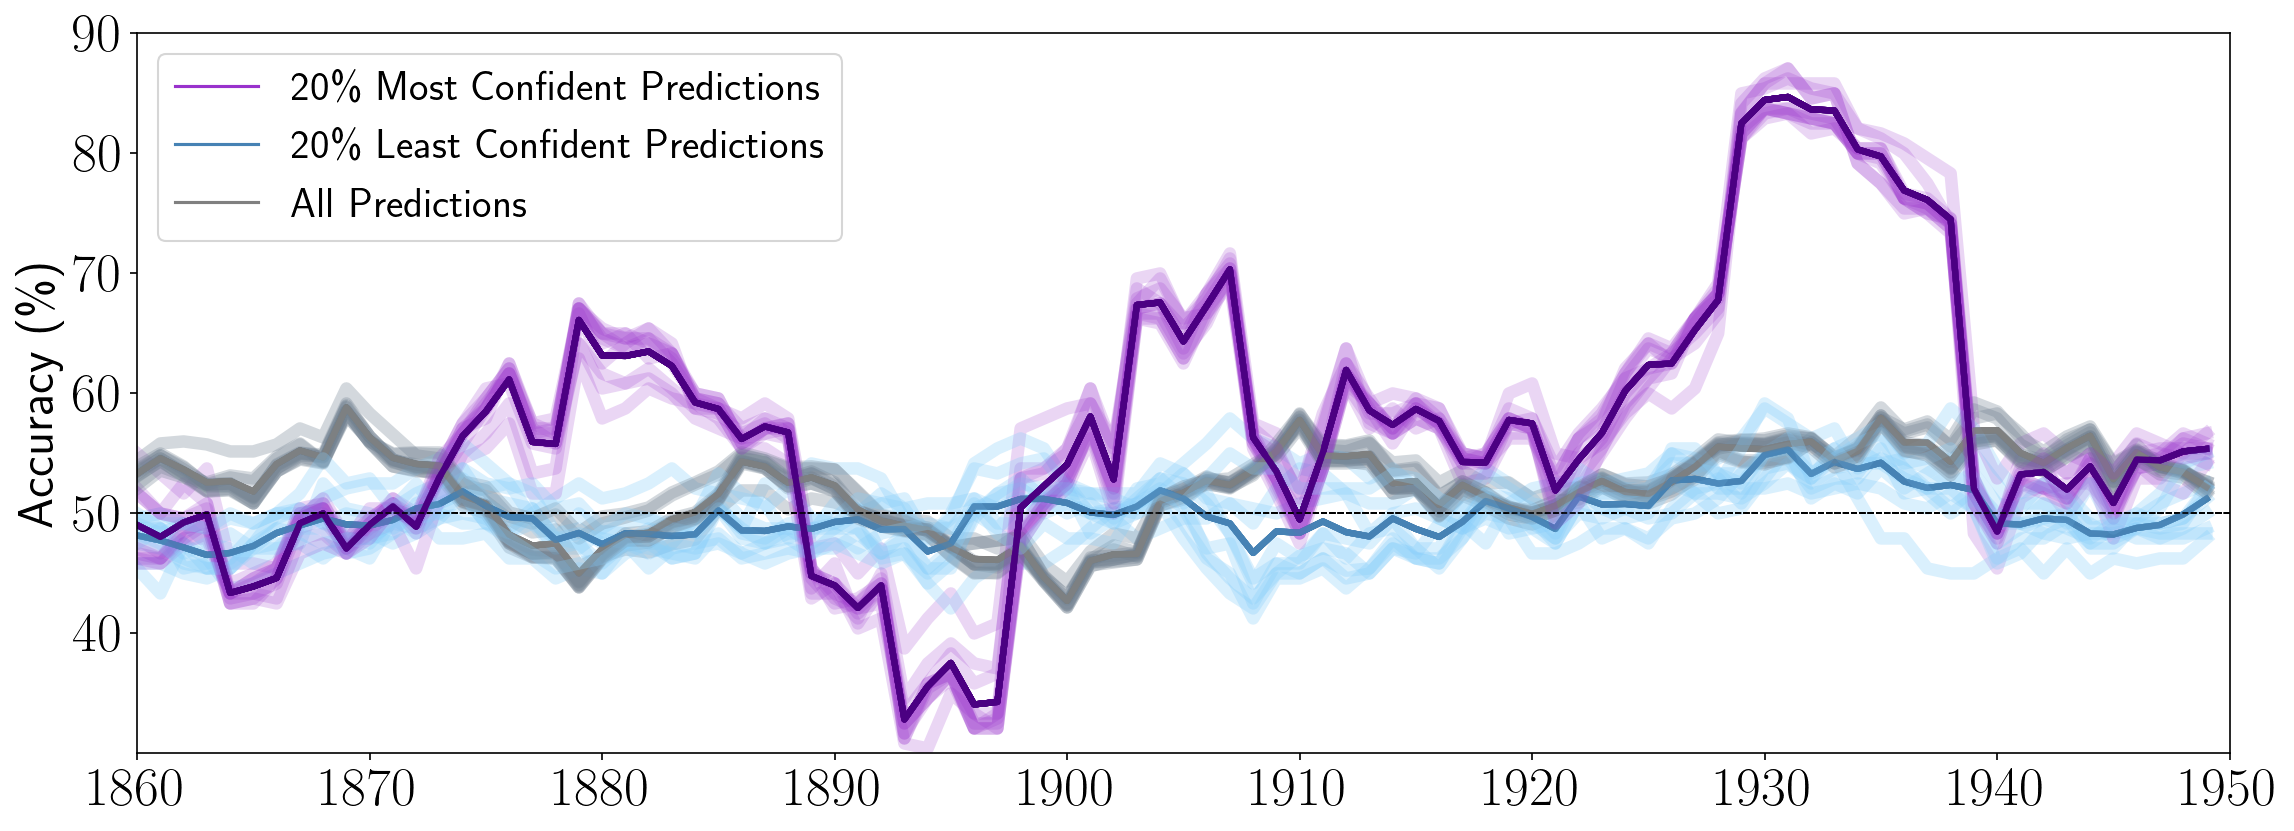

In [145]:
#Plot all the Seeds from all Experiments 
fig, ax = plt.subplots(1,1, sharex= True, figsize=(18,6))
exp = 8

for SEED in np.arange(0,10):
    ax.plot(timeplot, np.zeros(len(timeplot)),color='darkorchid')
    ax.plot(timeplot, np.zeros(len(timeplot)),color='steelblue')
    ax.plot(timeplot, np.zeros(len(timeplot)),color='gray')

    ax.plot(timeplot, accuracy_trained_runavg[exp,SEED,:], color='slategrey', alpha=0.3, linewidth=6)
    ax.plot(timeplot, mean_all_preds[exp,:], color='gray', alpha=0.6, linewidth=3)
    ax.plot(timeplot, least_confident_preds_runavg[exp,SEED,:],  color='lightskyblue', alpha=0.3, linewidth=6)
    ax.plot(timeplot, mean_least_conf_preds[exp,:], color='steelblue', alpha=0.6,  linewidth=3)  
    ax.plot(timeplot, confident_preds_runavg[exp,SEED,:], color='darkorchid', alpha= 0.2,linewidth=6)
    ax.plot(timeplot, mean_conf_preds[exp,:], color='indigo', linewidth=3)

    ax.set(xlim=(timeplot[0],timeplot[-1]+1))
    ax.set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
    ax.set(ylim=(30,90))
    ax.set(yticks=(np.arange(40,95, step=10)))
    ax.set_ylabel('Accuracy (\%)',fontsize = 24)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=0.75)

labels = ['20\% Most Confident Predictions','20\% Least Confident Predictions', 'All Predictions']
fig.subplots_adjust(top=0.91, hspace=0.3)
#plt.suptitle((str(running_window_yr)+'-yr Windows of Accuracy for Confident Predictions for '+REGION_TAND), fontsize='25')
plt.legend(labels, loc='upper left',ncol=1, fontsize=20) #, bbox_to_anchor=(1, 3.0)
plt.yticks(fontsize=26)
plt.xticks(fontsize=26)
#plt.savefig(ddir_figs+'accuracy_vs_confidence_20percmost_leastconfident'+str(running_window_yr)+'yr_runavg_exp_'+REGION_TAND+'_allseeds.png', format='png')

## Climate Mode Analysis - don't use; go to other script
### Binomial Stats

In [ ]:
from scipy.stats import binom
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
exp_num

In [ ]:
ind = 0 
total_neg_days = 0
total_pos_days = 0
total_days = 0
num_experiments = 10
num_seeds = 10 

#confidence params
conf_level = 'most' #OR least
statement = 20
per = 100-statement #percentile; this number can be stated as "the statement% conf_level confident predictions"; ex- the 20% most confident predictions  
subset = 'all'
c = 0 #negative pred = 0; positive pred = 1

timeplot_full = np.arange(1850,1950)
array_size = len(timeplot_full) - running_window_yr
timeplot = timeplot_full[running_window_yr:(len(timeplot_full))]

NLABEL = 2

climate_mode = 'PDO'

running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28
running_window = running_window_yr * days_per_annualszn

YEARS = '1850-1949'
STRT = pd.to_datetime('11-01-1850')
END   = pd.to_datetime('2-28-1949')  + dt.timedelta(days=1)

STRT_index = pd.to_datetime('01-01-1851')
END_index   = pd.to_datetime('12-30-1949')  + dt.timedelta(days=1)
time_range_index = xr.cftime_range(str(STRT_index)[:10], str(END_index)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp

In [ ]:
climate_mode = 'PDO'

example = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(9)+'_historical_ens'+str(9)+'_mo_atm_1851-1949.nc')['pc']
example_time = np.array(example.time)

mode_index = xr.DataArray(np.zeros([num_experiments,1188]),dims = ['experiment','time'],coords = [('experiment',np.arange(0,num_experiments)),('time',example_time)])

#mode_index = np.zeros([10,1188])
mode_index[0,:] = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(9)+'_historical_ens'+str(9)+'_mo_atm_1851-1949.nc')['pc']
for ugh in np.arange(1,10):
    mode_index[ugh,:] = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(ugh-1)+'_historical_ens'+str(ugh-1)+'_mo_atm_1851-1949.nc')['pc']

In [ ]:
#Open a file to get dimensions
sst_file = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/raw_files_timeconcat_monthly/'+'SST_global_1850-1949_ens0_dailyanom_detrend.nc')#['SST']
sst_lat = np.array(sst_file.lat)
sst_lon = np.array(sst_file.lon)
sst_time = np.array(sst_file.time)

prect_file = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/exp_1/exp_100/'+'PRECT_tropfullband_1850-1949_ens0_dailyanom_detrend.nc')#['SST']
prect_lat = np.array(prect_file.lat)
prect_lon = np.array(prect_file.lon)
prect_time = np.array(prect_file.time)


In [ ]:
# <<< EMPTY FILES FOR READING IN >>>>>>>>>>
acc_v_conf_test = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
acc_v_conf_val = xr.DataArray(np.zeros([num_experiments,num_seeds,20]),dims = ['experiment','seed','conf_ints'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('conf_ints',np.arange(0,20))])
conf_correct_preds_comp_2 = xr.DataArray(np.zeros([num_experiments,num_seeds,22, 144]),dims = ['experiment','seed', 'lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)), ('lat',np.arange(0,22)), ('lon',np.arange(0,144))])
conf_correct_preds_SST_comp = xr.DataArray(np.zeros([num_experiments,len(sst_lat), len(sst_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',sst_lat), ('lon',sst_lon)])
conf_correct_preds_SST_comp_2 = xr.DataArray(np.zeros([num_experiments,len(sst_lat), len(sst_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',sst_lat), ('lon',sst_lon)])

conf_correct_preds_PRECT_comp = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',prect_lat), ('lon',prect_lon)])
conf_correct_preds_PRECT_comp_2 = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',prect_lat), ('lon',prect_lon)])

conf_correct_preds_full = xr.DataArray(np.zeros([num_experiments,num_seeds,len(prect_lat), len(prect_lon)]),dims = ['experiment','seed', 'lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)), ('lat',prect_lat), ('lon',prect_lon)])

accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
least_confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
overall_accuracy_all_trained = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
conf_seed_winner_runavg = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
conf_seed_loser_runavg = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])

accuracy_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
accuracy_seed_loser_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])

sst_file_all = xr.DataArray(np.zeros([num_experiments,len(sst_time), len(sst_lat), len(sst_lon)]),dims = ['experiment','time','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('time',sst_time), ('lat',sst_lat), ('lon',sst_lon)])
prect_file_all = xr.DataArray(np.zeros([num_experiments,len(prect_time), len(prect_lat), len(prect_lon)]),dims = ['experiment','time','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('time',prect_time), ('lat',prect_lat), ('lon',prect_lon)])

sst_lowacc_allens = xr.DataArray(np.zeros([num_experiments,len(sst_lat), len(sst_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',sst_lat), ('lon',sst_lon)])
sst_highacc_allens = xr.DataArray(np.zeros([num_experiments,len(sst_lat), len(sst_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('lat',sst_lat), ('lon',sst_lon)])

mode_index = xr.DataArray(np.zeros([num_experiments,1188]),dims = ['experiment','time'],coords = [('experiment',np.arange(0,num_experiments)),('time',example_time)])
pos_percentage = xr.DataArray(np.zeros(num_experiments))
neg_percentage = xr.DataArray(np.zeros(num_experiments))

In [ ]:
exp_num = 1

In [ ]:
#time_range_ndjf

In [ ]:
#for sub_exp in np.arange(101,103):
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
#for sub_exp in [401,402,403,404,406]:
    EXPERIMENT = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
    Xdata_folder = 'exp_1/exp_'+str(sub_exp-(exp_num-1)*100)
    Ydata_folder = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
    
    ddir_X = '/Users/marcodia/Research/Data/processed_fields/'+Xdata_folder+'/'
    ddir_Y = '/Users/marcodia/Research/Data/processed_fields/'+Ydata_folder+'/'
    ddir_out = ddir_Y  #'/Users/marcodia/Research/Data/processed_fields/'+'check_data/' 
    ddir_trained = '/Users/marcodia/Research/Data/processed_fields/'+EXPERIMENT+'/'
    dir_out_trained = ddir_trained 
    ddir_figs = '/Users/marcodia/Research/Data/processed_fields/'+EXPERIMENT[:5]+'/figs/'
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    print(testing_ens)
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)
    
    time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
    time_range_ndjf = time_range.where(funcs.is_ndjf(time_range.month)).dropna()
    TIME_X = xr.DataArray(time_range_ndjf + dt.timedelta(days=0), dims=['time'])     
    TIME_Y = xr.DataArray(time_range_ndjf + dt.timedelta(days=lead+days_average), dims=['time'])                                                           
    X_TEST_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
    Xtest = xr.open_dataarray(ddir_X+X_TEST_finame)
    Xtest = Xtest.where(Xtest.time == TIME_X, drop=True)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            acc_v_conf_test[ind,:,:] = xr.open_dataarray(ddir_trained+'confidence_vs_accuracy_TESTING_'+EXPERIMENT[-3:]+'_allseeds.nc')
            acc_v_conf_val[ind,:,:] = xr.open_dataarray(ddir_trained+'confidence_vs_accuracy_VALIDATION_'+EXPERIMENT[-3:]+'_allseeds.nc')
            #conf_correct_preds_PRECT_comp[ind,ind2,:,:] = xr.open_dataarray(ddir_trained+subset+'TIMEMEAN_'+str(statement)+'perc_'+conf_level+'confident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'_class'+str(c)+'.nc')
            #conf_correct_preds[ind,ind2,:,:,:] = xr.open_dataarray(ddir_trained+subset+'_'+str(statement)+'perc_'+conf_level+'confident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'_class'+str(c)+'.nc')
            #conf_correct_preds[ind,ind2,:,:] = xr.open_dataarray(ddir_trained+subset+'TIMEMEAN_20perc_mostconfident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'_class'+str(c)+'.nc')
            
            conf_correct_preds_full[ind,ind2,:,:] = xr.open_dataarray(ddir_trained+subset+'TIMEMEAN_20perc_mostconfident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'_class'+str(c)+'.nc')
            accuracy_trained_runavg[ind,ind2,:] = xr.open_dataarray(ddir_trained+'accuracy_testdata_'+str(running_window_yr)+'yr_runavg_exp'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'.nc')
            overall_accuracy_all_trained[ind,:] = xr.open_dataarray(ddir_trained+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_trained+'20confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            least_confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_trained+'80confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            
            ind2 = ind2+1
       
    seed_winner_trained = np.argmax(np.array(overall_accuracy_all_trained[ind,:]))
    accuracy_seed_winner_trained[ind,:] = accuracy_trained_runavg[ind,seed_winner_trained,:]
    conf_seed_winner_runavg[ind,:] = confident_preds_runavg[ind,seed_winner_trained,:]

    file_dates = xr.open_dataarray(ddir_trained+subset+'_'+str(statement)+'perc_'+conf_level+'confident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(RANDOM_SEED[seed_winner_trained])+'_class'+str(c)+'.nc')
    #print(file_dates.shape)
    
    #if ind == 0:
    sst_file_all[ind,:,:,:] = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/raw_files_timeconcat_monthly/SST_global_1850-1949_ens'+str(testing_ens)+'_dailyanom_detrend.nc')
    sst_daily = sst_file.interp(time = time_range_index)
    sst_winter = sst_file_all[ind,:,:,:].where(sst_file_all[ind,:,:,:].time == TIME_X, drop = True)
    #sst_winter[ind,:,:,:] = sst_file.where(sst_file.time == TIME_X, drop = True)

    prect_file_all[ind,:,:,:] = xr.open_dataarray(ddir_X+'PRECT_tropfullband_1850-1949_ens'+str(testing_ens)+'_dailyanom_detrend.nc')
#     else:
#         sst_file = xr.open_dataarray(ddir_trained+'SST_global_1850-1949_ens'+str(ind-1)+'_dailyanom_detrend.nc')
#         prect_file = xr.open_dataarray(ddir_trained+'PRECT_tropfullband_1850-1949_ens'+str(ind-1)+'_dailyanom_detrend.nc')
    
    #sst_conf_correct = sst_file.where(sst_file.time == file_dates.time, drop=True)
    sst_conf_correct = sst_daily.where(sst_daily.time == file_dates.time, drop=True)
    
    prect_conf_correct = prect_file.where(prect_file.time == file_dates.time, drop=True)
    #print(sst_conf_correct.shape)

    # conf_correct_preds_SST_comp[ind,:,:]= np.mean(sst_conf_correct,axis=0)
    # conf_correct_preds_PRECT_comp[ind,:,:]= np.mean(prect_conf_correct,axis=0)

    ######                              
    yr_high = np.argmax(np.array(conf_seed_winner_runavg[ind,:]))
    yr_low = np.argmin(np.array(conf_seed_winner_runavg[ind,:]))


    if yr_high <20:
        yr_high = 20
    else:
        yr_high = yr_high

    if yr_low <20:
        yr_low = 20
    else:
        yr_low = yr_low

    yr_high_range = conf_seed_winner_runavg[ind,(yr_high-10):(yr_high+10)]
    yr_low_range = conf_seed_winner_runavg[ind,(yr_low-10):(yr_low+10)]
    #print(yr_low)
    #print(yr_low_range)
    #print(confident_preds_runavg)
    
    yr_high_strt = int(yr_high_range.year_avg[0])
    yr_high_end = int(yr_high_range.year_avg[-1])
    yr_low_strt = int(yr_low_range.year_avg[0])
    yr_low_end = int(yr_low_range.year_avg[-1])

    STRT_high = pd.to_datetime('02-01-'+str(yr_high_strt))
    END_high   = pd.to_datetime('12-01-'+str(yr_high_end))  + dt.timedelta(days=1)
    time_range_high = xr.cftime_range(str(STRT_high)[:10], str(END_high)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
    time_range_high

    STRT_low = pd.to_datetime('02-01-'+str(yr_low_strt))
    END_low   = pd.to_datetime('12-01-'+str(yr_low_end))  + dt.timedelta(days=1)
    time_range_low = xr.cftime_range(str(STRT_low)[:10], str(END_low)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp

    TIME_HIGH = xr.DataArray(time_range_high + dt.timedelta(days=0), dims=['time']) 
    sst_high_acc = sst_winter.where(sst_winter.time == TIME_HIGH, drop = True)
    sst_high_acc_daily = sst_high_acc.interp(time = time_range_index)
    
    TIME_LOW = xr.DataArray(time_range_low + dt.timedelta(days=0), dims=['time']) 
    sst_low_acc = sst_winter.where(sst_winter.time == TIME_LOW, drop = True)
    sst_low_acc_daily = sst_low_acc.interp(time = time_range_index)
########        
#     file_dates_2 = xr.open_dataarray(ddir_trained+subset_2+'_'+str(statement_2)+'perc_'+conf_level_2+'confident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(RANDOM_SEED[seed_winner_trained])+'_class'+str(c_2)+'.nc')
    
#     # if ind == 0:
#     sst_file_2 = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/raw_files_timeconcat_monthly/SST_global_1850-1949_ens'+str(testing_ens)+'_dailyanom_detrend.nc')
#     prect_file_2 = xr.open_dataarray(ddir_trained+'PRECT_tropfullband_1850-1949_ens'+str(testing_ens)+'_dailyanom_detrend.nc')
# #     else:
# #         sst_file_2 = xr.open_dataarray(ddir_trained+'SST_global_1850-1949_ens'+str(ind-1)+'_dailyanom_detrend.nc')
# #         prect_file_2 = xr.open_dataarray(ddir_trained+'PRECT_tropfullband_1850-1949_ens'+str(ind-1)+'_dailyanom_detrend.nc')
        
#     sst_conf_correct_2 = sst_file_2.where(sst_file_2.time == file_dates_2.time, drop=True)
#     prect_conf_correct_2 = prect_file_2.where(prect_file_2.time == file_dates_2.time, drop=True)
#     #print(sst_conf_correct_2.shape)
    
#     conf_correct_preds_SST_comp_2[ind,:,:]= np.mean(sst_conf_correct_2,axis=0)
#     conf_correct_preds_PRECT_comp_2[ind,:,:]= np.mean(prect_conf_correct_2,axis=0)
    
    mode_index[ind,:] = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(testing_ens)+'_historical_ens'+str(testing_ens)+'_mo_atm_1851-1949_cbf.nc')['pc']
    
    daily_index = mode_index[ind,:].interp(time = time_range_index) #converts the climate mode index into a daily index 
    #plt.plot(daily_index)
    #temp = daily_index.where(daily_index.time == file_dates.time, drop=True)
    
##################################################
    window_conf = TIME_HIGH.where(TIME_HIGH == file_dates.time, drop=True)
    #window_conf = TIME_LOW.where(TIME_LOW == file_dates.time, drop=True)
##################################################
    #print(window_conf) 
    
    temp = daily_index.where(daily_index.time == window_conf, drop=True)
    sst_temp = sst_conf_correct.where(sst_conf_correct.time == window_conf, drop=True)
    
    prect_temp= prect_conf_correct.where(prect_conf_correct.time == window_conf, drop=True)
    #print(temp.shape)
    #print(sst_temp.shape)
    
    conf_correct_preds_SST_comp[ind,:,:]= np.mean(sst_temp,axis=0)
    conf_correct_preds_PRECT_comp[ind,:,:]= np.mean(prect_temp,axis=0)
    #conf_correct_preds_PRECT_comp[ind,:,:]= np.mean(prect_conf_correct,axis=0)

    
    pos_climatemode = temp.where(temp>=0.2, drop=True)
    neg_climatemode = temp.where(temp<0.2, drop=True)
    
#     # pos_percentage[ind] = np.array((len(pos_climatemode.time)/len(file_dates.time))*100)   
#     # neg_percentage[ind] = np.array((len(neg_climatemode.time)/len(file_dates.time))*100)
    
    pos_percentage[ind] = np.array((len(pos_climatemode.time)/len(window_conf.time))*100)   
    neg_percentage[ind] = np.array((len(neg_climatemode.time)/len(window_conf.time))*100)
    
#     #print(neg_percentage)
    
    print("Test Ensemble member "+str(testing_ens))
    if c == 0:
        print(str(np.round(np.array(pos_percentage[ind]),2))+ "% Postitive PDO days during a negative anomaly in "+REGION_TAND)        
        print(str(np.round(np.array(neg_percentage[ind]),2))+ "% Negative PDO days during a negative anomaly in "+REGION_TAND)
    if c == 1:
        print(str(np.round(np.array(pos_percentage[ind]),2))+ "% Postitive PDO days during a positive anomaly in "+REGION_TAND)
        print(str(np.round(np.array(neg_percentage[ind]),2))+ "% Negative PDO days during a positive anomaly in "+REGION_TAND)
    
#     #total_days = total_days + len(file_dates.time)
    total_days = total_days + len(window_conf.time)
    
    total_neg_days = total_neg_days+len(neg_climatemode.time)
    total_neg_days_perc = (total_neg_days/total_days)*100
    
    total_pos_days = total_pos_days+len(pos_climatemode.time)
    total_pos_days_perc = (total_pos_days/total_days)*100
    
    daily_index_pos = daily_index.where(daily_index>=0, drop= True)
    pos_perc_total = (len(daily_index_pos)/len(daily_index))
    daily_index_neg = daily_index.where(daily_index<0, drop= True)
    neg_perc_total = (len(daily_index_neg)/len(daily_index))
    # print(pos_perc_total)
    # print(neg_perc_total)
    
    if c == 0:
        binom_test = stats.binom_test(len(neg_climatemode.time),n=len(sst_conf_correct.time),p=neg_perc_total,alternative ='two-sided')
        binom_test_total = stats.binom_test(total_neg_days,n=total_days,p=neg_perc_total,alternative ='two-sided')
    if c == 1:
        binom_test = stats.binom_test(len(pos_climatemode.time),n=len(sst_conf_correct.time),p=pos_perc_total,alternative ='two-sided')
        binom_test_total = stats.binom_test(total_pos_days,n=total_days,p=pos_perc_total,alternative ='two-sided')
    
    if binom_test < .01:
        print("Statistically Significant")
    else:
        print("NOT stat sig")
        
    # if binom_test_total < .01:
    #     print("Statistically Significant")
    # else:
    #     print("NOT stat sig")
    
    ind = ind + 1

if c == 0:
    print(str(np.round(np.array(total_neg_days_perc),2))+ "% Negative "+climate_mode+" days during a negative anomaly in "+REGION_TAND)
    print(str(np.round(np.array(total_pos_days_perc),2))+ "% Positive "+climate_mode+" days during a negative anomaly in "+REGION_TAND) 
if c == 1:
    print(str(np.round(np.array(total_neg_days_perc),2))+ "% Negative "+climate_mode+" days during a positive anomaly in "+REGION_TAND) 
    print(str(np.round(np.array(total_pos_days_perc),2))+ "% Positive "+climate_mode+" days during a positive anomaly in "+REGION_TAND) 

print("ALL DAYS FROM ALL ENSEMBLES")
if binom_test_total < .01:
    print("Statistically Significant")
else:
    print("NOT stat sig")


In [ ]:
hi